date  1. open  2. high    3. low  4. close   5. volume
0     2020-08-17  464.250   464.35  455.8501    458.43  29431414.0
1     2020-08-14  459.315   460.00  452.1800    459.63  41391302.0
2     2020-08-13  457.720   464.17  455.7100    460.04  52520516.0
3     2020-08-12  441.990   453.10  441.1900    452.04  41486205.0
4     2020-08-11  447.875   449.93  436.4267    437.50  46975594.0
...          ...      ...      ...       ...       ...         ...
5227  1999-11-05   84.620    88.37   84.0000     88.31   3721500.0
5228  1999-11-04   82.060    85.37   80.6200     83.62   3384700.0
5229  1999-11-03   81.620    83.25   81.0000     81.50   2932700.0
5230  1999-11-02   78.000    81.69   77.3100     80.25   3564600.0
5231  1999-11-01   80.000    80.69   77.3700     77.62   2487300.0

[5232 rows x 6 columns]
(4662, 50, 5)
(519, 50, 5)
unscaled_y:[[324.39]
 [324.66]
 [320.75]
 ...
 [ 81.62]
 [ 78.  ]
 [ 80.  ]]


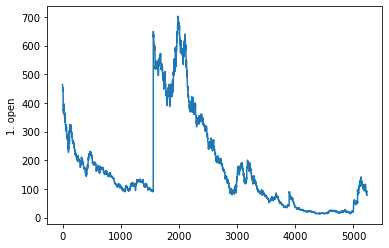

In [2]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate, BatchNormalization
from tensorflow.keras import optimizers
import numpy as np
np.random.seed(42)
tf.random.set_seed(42)

from util import csv_to_dataset, history_points, btc_csv_to_dataset

tf.__version__

# dataset

ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser = csv_to_dataset('./data/AAPL_daily.csv')
# ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser = btc_csv_to_dataset('BTC-USD_daily.csv')
# ohlcv = open, high, low, close, volume

test_split = 0.9
n = int(ohlcv_histories.shape[0] * test_split)

ohlcv_train = ohlcv_histories[:n]
tech_ind_train = technical_indicators[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
tech_ind_test = technical_indicators[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

print(ohlcv_train.shape)
print(ohlcv_test.shape)
print(f"unscaled_y:{unscaled_y}")

In [2]:

# model architecture

# define two sets of inputs
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')

# the first branch operates on the first input
x = LSTM(64, name='lstm_0', return_sequences=True)(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = BatchNormalization(name='batch_norm_0')(x)

x = LSTM(64, name='lstm_1')(x)
x = Dropout(0.2, name='lstm_dropout_1')(x)
x = BatchNormalization(name='batch_norm_1')(x)

# model.add(LSTM(64))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
x = Dense(32, name='dense_output_0', activation='relu')(x)
x = Dropout(0.2, name='dense_dropout_0')(x)

lstm_branch = Model(inputs=lstm_input, outputs=x)

# the second branch opreates on the second input
y = Dense(64, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.2, name='tech_dropout_0')(y)

y = Dense(32, name='tech_dense_1')(dense_input)
y = Activation("relu", name='tech_relu_1')(y)
y = Dropout(0.2, name='tech_dropout_1')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)

# combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
z = Dense(1, activation="linear", name='dense_out')(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')
model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
127/132 [===========================>..] - ETA: 0s - loss: 0.0444WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000025B8D9F0D38> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the fu

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
104.44885973918466


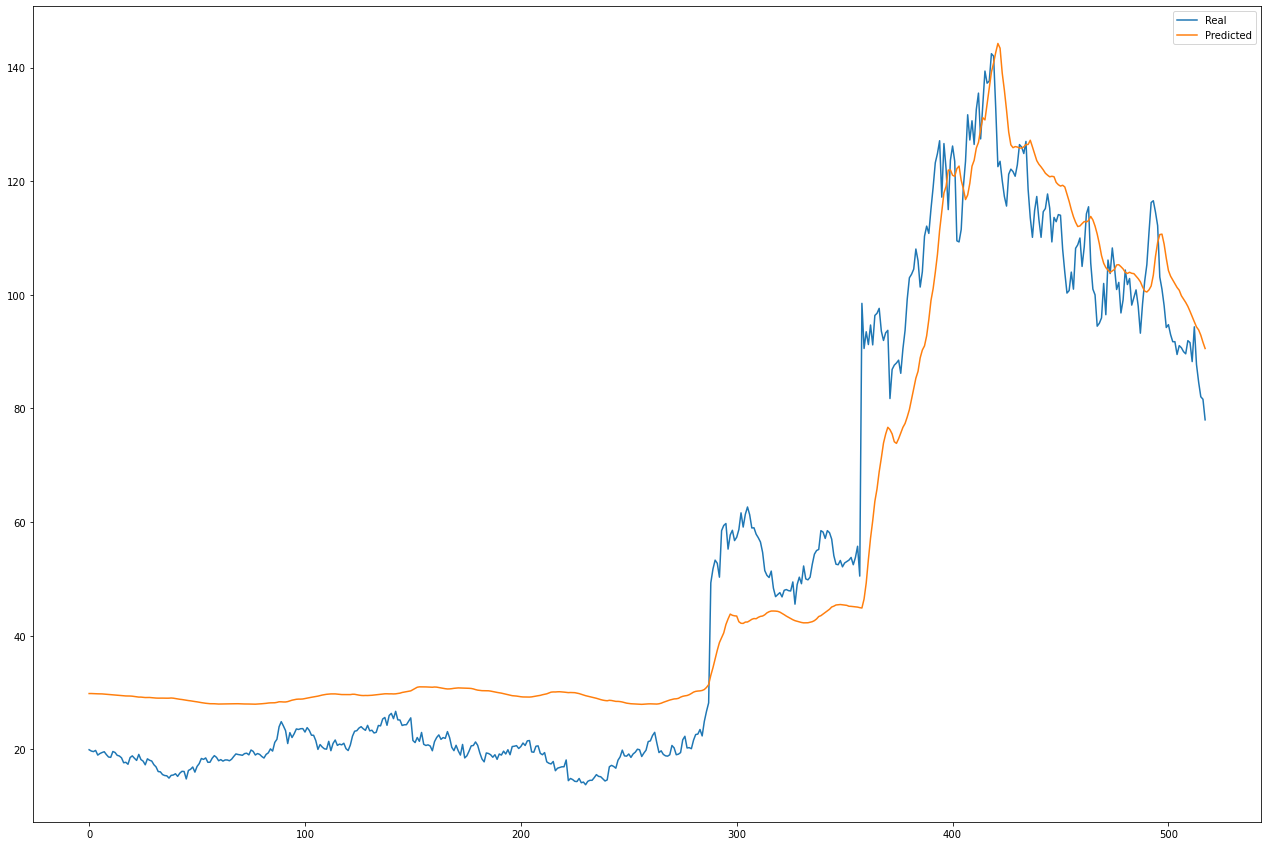

In [3]:

# evaluation

y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict([ohlcv_histories, technical_indicators])
y_predicted = y_normaliser.inverse_transform(y_predicted)
assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

# real = plt.plot(unscaled_y[start:end], label='real')
# pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

import time
model.save(f'./models/ohlcv-ind-{time.time()}.h5')

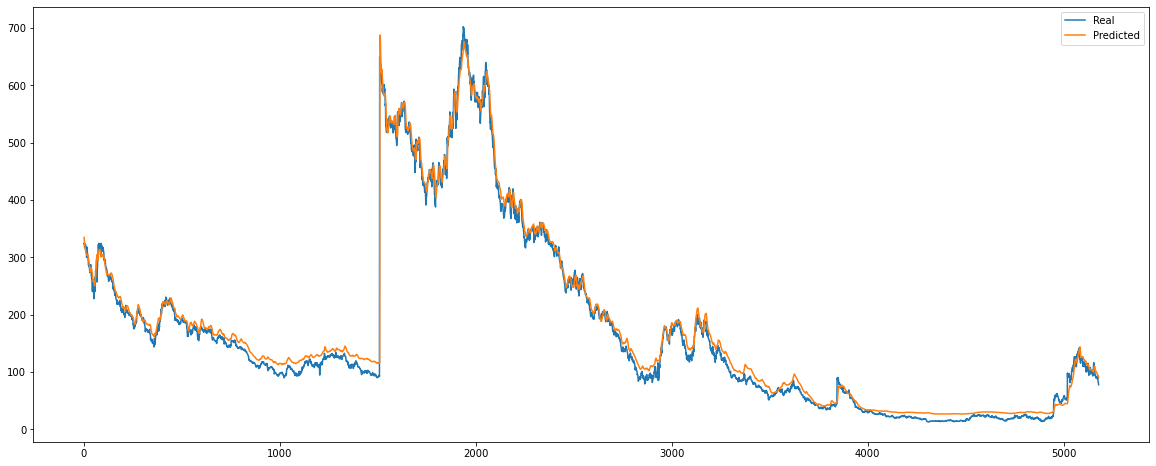

In [4]:
plt.figure(figsize=(20,8))
real = plt.plot(unscaled_y[start:end], label='real')
pred = plt.plot(y_predicted[start:end], label='predicted')
plt.legend(['Real', 'Predicted'])

In [5]:
y_predicted

array([[335.02435 ],
       [329.9484  ],
       [326.68    ],
       ...,
       [ 91.65278 ],
       [ 90.552246],
       [ 89.43036 ]], dtype=float32)

In [12]:
predicted_price_tomorrow = np.squeeze(y_normaliser.inverse_transform(model.predict([ohlcv_histories, technical_indicators]))) 
buys = []
sells = []
thresh = 7.77
print(predicted_price_tomorrow)
start = 0
end = -1

x = -1

# for prediction in predicted_price_tomorrow:

# for ohlcv, tech_ind in zip(ohlcv_test[start: end], tech_ind_test[start: end]):
for i, ohlcv in enumerate(ohlcv_histories[start:end-7]):
    normalised_price_today = ohlcv[-1][0]
    normalised_price_today = np.array([[normalised_price_today]])
    price_today = y_normaliser.inverse_transform(normalised_price_today)[0][0]
    price_tomorrow = predicted_price_tomorrow[i+7]
    delta = price_tomorrow - price_today
   # print( price_tomorrow, price_today)

    # if  price_tomorrow > (price_today*thresh):
    #     buys.append((x, price_today))
    # elif price_tomorrow < (price_today*thresh):
    #     sells.append((x, price_today))
    if delta > thresh:
        buys.append((x, price_today))
    elif delta < -thresh:
        sells.append((x, price_today))
    x += 1
print(f"buys: {len(buys)}")
print(f"sells: {len(sells)}")

[335.02435  329.9484   326.68     ...  91.65278   90.552246  89.43036 ]
buys: 2761
sells: 463


earnings: $5382702.623647788
[[324.39]
 [324.66]
 [320.75]
 ...
 [ 81.62]
 [ 78.  ]
 [ 80.  ]]


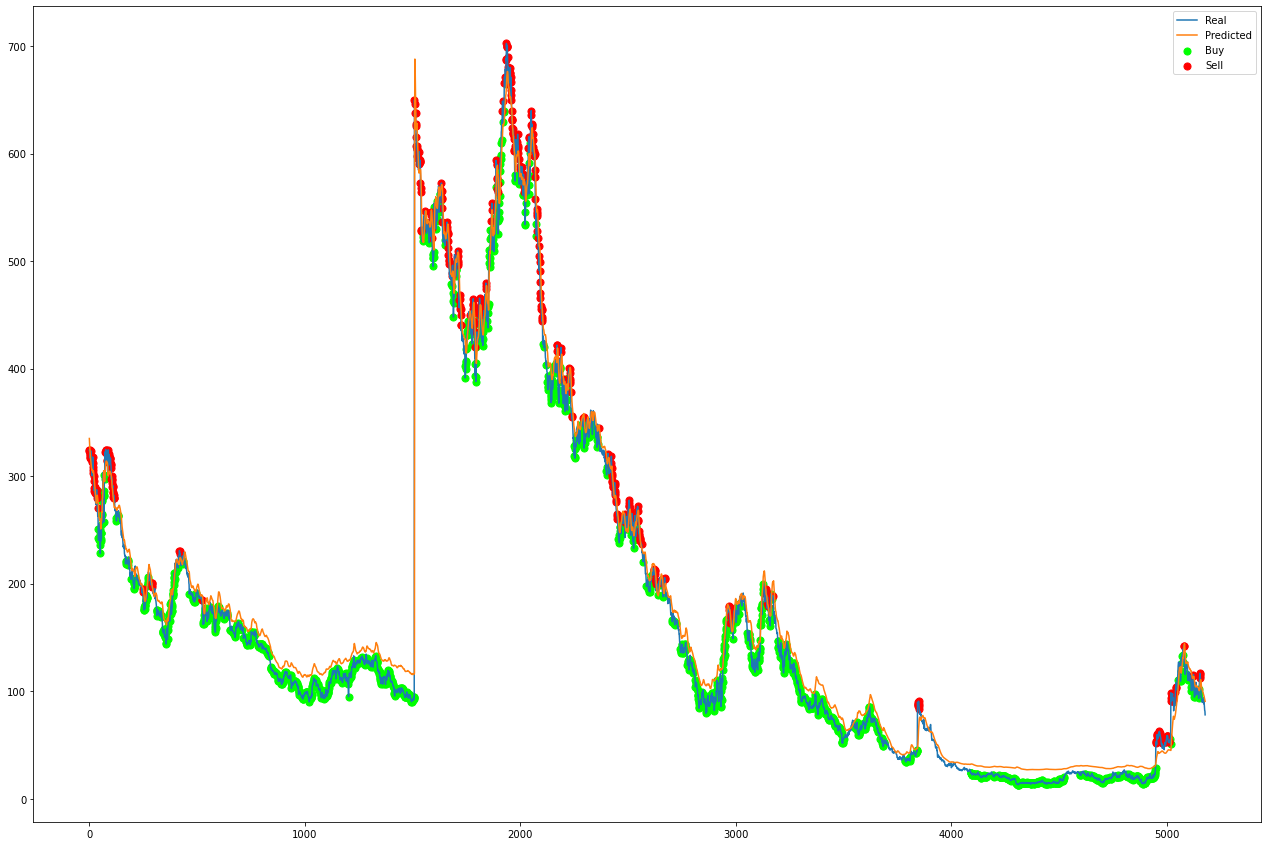

In [14]:
# import numpy as np
# from tensorflow.keras.models import load_model
# from util import csv_to_dataset, history_points

# model = load_model('technical_model-1597701365.3351254.h5')

# ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser = csv_to_dataset('MSFT_daily.csv')

# test_split = 0.9
# n = int(ohlcv_histories.shape[0] * test_split)

# ohlcv_train = ohlcv_histories[:n]
# tech_ind_train = technical_indicators[:n]
# y_train = next_day_open_values[:n]

# ohlcv_test = ohlcv_histories[n:]
# tech_ind_test = technical_indicators[n:]
# y_test = next_day_open_values[n:]

# unscaled_y_test = unscaled_y[n:]

# print(ohlcv_test.shape, tech_ind_test.shape)
# y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
# y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)

# buys = []
# sells = []
# thresh = 0.1

# start = 0
# end = -1

# x = -1

#  predicted_price_tomorrow = np.squeeze(y_normaliser.inverse_transform(model.predict(ohlcv_histories, technical_indicators))) 


# # for ohlcv, tech_ind in zip(ohlcv_test[start: end], tech_ind_test[start: end]):
# #     normalised_price_today = ohlcv[-1][0]
# #     normalised_price_today = np.array([[normalised_price_today]])
# #     price_today = y_normaliser.inverse_transform(normalised_price_today)

# #     predicted_price_tomorrow = np.squeeze(y_normaliser.inverse_transform(model.predict(ohlcv, tech_ind)))
# #     delta = predicted_price_tomorrow - price_today
# #     if delta > thresh:
# #         buys.append((x, price_today[0][0]))
# #     elif delta < -thresh:
# #         sells.append((x, price_today[0][0]))
# #     x += 1
# print(f"buys: {len(buys)}")
# print(f"sells: {len(sells)}")


def compute_earnings(buys_, sells_):
    purchase_amt = 1000
    stock = 0
    balance = 0
    while len(buys_) > 0 and len(sells_) > 0:
        if buys_[0][0] < sells_[0][0]:
            # time to buy $10 worth of stock
            balance -= purchase_amt
            stock += purchase_amt / buys_[0][1]
            buys_.pop(0)
        else:
            # time to sell all of our stock
            balance += stock * sells_[0][1]
            stock = 0
            sells_.pop(0)
    print(f"earnings: ${balance}")


# we create new lists so we dont modify the original
compute_earnings([b for b in buys], [s for s in sells])

import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

# real = plt.plot(unscaled_y_test[start:end], label='real')
# pred = plt.plot(y_test_predicted[start:end], label='predicted')

if len(buys) > 0:
    plt.scatter(list(list(zip(*buys))[0]), list(list(zip(*buys))[1]), c='#00ff00', s=50)
if len(sells) > 0:
    plt.scatter(list(list(zip(*sells))[0]), list(list(zip(*sells))[1]), c='#ff0000', s=50)

print(unscaled_y)
real = plt.plot(unscaled_y[start:end], label='real')
pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted', 'Buy', 'Sell'])

plt.show()
